In [1]:
import patch_manager as pmang
from reconstructor import Reconstructor
from skimage import io
import numpy as np
recon = Reconstructor()

sperm_path2 = 'C:\\Users\\Blomst\\sperm_0p2_40hz_12t_00068.BTF'
X = io.imread(sperm_path2)


#test_image = "c:\\users\\blomst\\groundtruth\\87\\5.png"

#img = io.imread(test_image, as_gray=True)*255
#pmang.show_patch_as_image(img, "lol")

In [21]:
#img = io.imread(test_image, as_gray=True)*255
#pmang.show_patch_as_image(img, "lol")


#window_size = 128
#patches_pr_layer = 15
#total_patches = 4096

res1 = []
res2 = []
for window_size in range(6,50):
    print(window_size)
    
    total_patches = 10*window_size*window_size
    patches_pr_layer = int(total_patches/800 + 10)
    rs = pmang.random_coordinates_all(X,patches_pr_layer,window_size, max=total_patches)
    patches = pmang.get_patches(X, rs, window_size)
    recon.get_pca(patches)
    res1.append([window_size, recon.n_var])
    res2.append([window_size*window_size, recon.n_var])
    #print(total_patches, ",", recon.n_var)

1000/1067
1000/1155
1000/1254
1000/1353
1000/1463
1000/1573
1000/1692
1000/1800
1000/1932
1000/2052
2000/2052
1000/2184
2000/2184
1000/2316
2000/2316
1000/2457
2000/2457
1000/2598
2000/2598
1000/2745
2000/2745
1000/2899
2000/2899
1000/3054
2000/3054
3000/3054
1000/3207
2000/3207
3000/3207
1000/3374
2000/3374
3000/3374
1000/3540
2000/3540
3000/3540
1000/3698
2000/3698
3000/3698
1000/3878
2000/3878
3000/3878
1000/4050
2000/4050
3000/4050
4000/4050
1000/4245
2000/4245
3000/4245
4000/4245
1000/4424
2000/4424
3000/4424
4000/4424
1000/4622
2000/4622
3000/4622
4000/4622
1000/4802
2000/4802
3000/4802
4000/4802


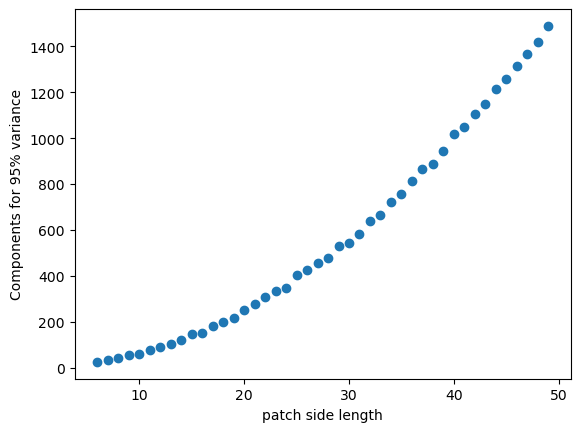

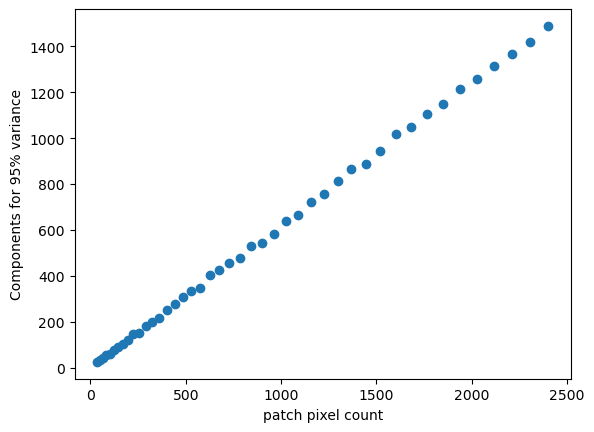

In [22]:
import matplotlib.pyplot as plt
def plot_points(points,x_label):
    x = [point[0] for point in points]
    y = [point[1] for point in points]
    plt.scatter(x, y)
    plt.xlabel(x_label)
    plt.ylabel('Components for 95% variance')
    plt.show()

plot_points(res1, "patch side length")
plot_points(res2, "patch pixel count")

In [3]:
recon.get_pca(patches)

(array([[ 0.00360681,  0.00359634,  0.0040848 , ...,  0.00543034,
          0.00486771,  0.00482568],
        [ 0.00249697,  0.00197942,  0.00194929, ..., -0.0003486 ,
         -0.00117885, -0.00208479],
        [-0.00329016, -0.00318853, -0.00473889, ..., -0.00033256,
         -0.00067277, -0.00090415],
        ...,
        [-0.00834067, -0.00197384, -0.00872963, ..., -0.0043275 ,
          0.0124571 ,  0.00740608],
        [-0.00723348, -0.0061332 ,  0.01155552, ...,  0.00436193,
          0.00232866,  0.00160797],
        [-0.00942889, -0.00387082, -0.011775  , ..., -0.00055386,
         -0.0057263 , -0.00017328]]),
 array([7.47165516e+03, 6.52652892e+03, 5.70036275e+03, ...,
        2.84128910e-11, 3.31808143e-12, 3.17882111e-12]),
 array([104.75586854, 104.84141888, 104.9191445 , ..., 104.2866458 ,
        104.22248305, 104.26421492]))

In [ ]:
reconstruction = recon.reconstruct_image(img, 300, window_size, 4)
pmang.save_patch_as_image(reconstruction, "c:\\users\\blomst\\Desktop\\recon_test.png")

In [ ]:
def convolution(x, i, j):
    I = len(x)-1
    J = len(x[0])-1
    if  (i==0 and j==0):
        return x[i+1,j]*1/2 + x[i+1,j+1]*1/2
    elif(i == I and j == J):
        return x[i-1,j]*1/2 + x[i-1,j-1]*1/2
    elif(i == I and j == 0):
        return x[i-1,j]*1/2 + x[i-1,j+1]*1/2
    elif(i == 0 and j == J):
        return x[i+1,j]*1/2 + x[i+1,j-1]*1/2
    elif(i==0):
        return x[i+1,j]*1/3 + x[i+1,j-1]*1/3 + x[i+1,j+1]*1/3
    elif(j==0):
        return x[i-1,j]*1/3 + x[i+1,j]*1/3 + x[i-1,j+1]*1/6 + x[i+1,j+1]*1/6
    elif(i == I):
        return x[i-1,j]*1/3 + x[i-1,j+1]*1/3 + x[i-1,j-1]*1/3
    elif(j == J):
        return x[i-1,j]*1/3 + x[i+1,j]*1/3 + x[i+1,j-1]*1/6 + x[i-1,j-1]*1/6
    else:
        return x[i-1,j]*1/6 + x[i+1,j]*1/6 + x[i+1,j-1]*1/6 + x[i-1,j+1]*1/6 + x[i+1,j+1]*1/6 + x[i-1,j-1]*1/6
    

def convolve_nth(x, nth, first):
    y = np.copy(x)
    for i in range(len(y)):
        for j in range(len(y[0])):
            if((i-first)%nth == 0):
                y[i,j] = convolution(y, i, j)
    return y

In [43]:
recon_file = io.imread("c:\\users\\blomst\\Desktop\\recon_test.png")

In [45]:


pmang.show_patch_as_image(recon_file, "yeet")

yes = convolve_nth(recon_file, 4, 0)

pmang.show_patch_as_image(yes, "yeet")
pmang.save_patch_as_image(yes, "c:\\users\\blomst\\Desktop\\recon_convolution.png")

In [37]:
def change_range(img):
    new_img = np.copy(img)
    min = 100
    max = 130
    new_max = 255
    for i in range(len(img)):
        for j in range(len(img[0])):
            new_number = (img[i][j]-min)/(max - min ) * new_max
            new_img[i][j] = new_number
    return new_img

pmang.show_patch_as_image(change_range(reconstruction), "yeet")

In [8]:
patch = X[87,6,20:148,50:178]
patch_full = X[87,6]
removed = pmang.remove_row_from_patch(patch, 34, window_size, recon.mu)
removed = pmang.remove_row_from_patch(removed, 35, window_size, recon.mu)
removed = pmang.remove_row_from_patch(removed, 36, window_size, recon.mu)
pmang.save_patch_as_image(patch, "e:\\overbevis_jon\\original.png")
pmang.save_patch_as_image(patch_full, "e:\\overbevis_jon\\original_full.png")
pmang.save_patch_as_image(removed, "e:\\overbevis_jon\\removed3.png")

path1 = "e:\\overbevis_jon\\recon\\"
path2 = "e:\\overbevis_jon\\comps_k\\"
path3 = "e:\\overbevis_jon\\comps\\"

pmang.make_directory(path1)
pmang.make_directory(path2)
pmang.make_directory(path3)
for i in range(4096):
    vec1 = recon.reconstruct_patch(removed, i)
    vec2 = recon.reconstruct_patch_n1(removed, i)*15 + recon.mu
    img1 = pmang.vec_2_patch(vec1,window_size)
    img2 = pmang.vec_2_patch(vec2,window_size)
    #print(np.shape(img1))
    #print(np.shape(img2))
    out1 = path1 + str(i) + ".png"
    out2 = path2 + str(i) + ".png"
    pmang.save_patch_as_image(img1,out1) 
    pmang.save_patch_as_image(img2,out2) 

KeyboardInterrupt: 

In [9]:
path3 = "e:\\overbevis_jon\\comps\\"
recon.save_principal_components_as_image (15, path3, window_size)


0

In [21]:
from PIL import Image
import os

def make_grid(folder_path, output_path):
    images = []
    for i in range(1024):
        filename = str(i) + '.png'
        img = Image.open(os.path.join(folder_path, filename))

        if(i==recon.n_var):
            img = Image.open(os.path.join(folder_path, "0.png"))

        images.append(img)
    width, height = images[0].size
    new_im = Image.new('RGB', (32 * width, 32 * height))
    x_offset = 0
    y_offset = 0
    for i in range(32):
        for j in range(32):
            new_im.paste(images[i*32+j], (x_offset, y_offset))
            x_offset += width
        y_offset += height
        x_offset = 0
    new_im.save(output_path)

make_grid('e:\\overbevis_jon\\comps', 'e:\\overbevis_jon\\comps.png')
make_grid('e:\\overbevis_jon\\comps_k', 'e:\\overbevis_jon\\comps_k.png')
make_grid('e:\\overbevis_jon\\recon', 'e:\\overbevis_jon\\recon.png')

In [4]:
print(recon.n_var)

3114
